In [1]:
#add project directory to python path
import sys
sys.path.append("..")
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline
from default import PROJECT_DIRECTORY, DATA_DIRECTORY

#Orphan Profile

##Load Halo Catlaogue

In [2]:
#load dark matter simulation
from halotools import sim_manager

#load halo catalogue to populate for mocks
simname = 'bolshoi_250'
halocat_1 = sim_manager.CachedHaloCatalog(simname = 'bolshoi_250', redshift=0.0, dz_tol=0.001,
                                          version_name='custom_w_clones_sub', halo_finder='Rockstar')

#print out column names
for name in halocat_1.halo_table.colnames: print(name)
print("number of (sub-)haloes: ", len(halocat_1.halo_table))

halo_upid
halo_first_acc_mvir
halo_acc_scale
halo_rvir
halo_vpeak
halo_macc
halo_first_acc_scale
halo_vy
halo_clone
halo_donor_ind
halo_half_mass_scale
halo_mvir
halo_T/|U|
halo_vmax_at_mpeak
halo_hostid
halo_y
halo_pid
halo_x
halo_z
halo_m200b
halo_m200c
halo_mvir_host_halo
halo_first_acc_vmax
halo_mpeak_scale
halo_vmax
halo_vacc
halo_nfw_conc
halo_id
halo_vx
halo_mpeak
halo_vz
halo_rs
number of (sub-)haloes:  19301666


In [ ]:
#set cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology

##Load Clone Halo Catalogue

In [3]:
#load dark matter simulation
from halotools import sim_manager

halocat_2 = sim_manager.CachedHaloCatalog(simname = 'bolshoi_250', redshift=0.0, dz_tol=0.001,
                                          version_name='custom_w_clones_ptcl', halo_finder='Rockstar')

#print out column names
for name in halocat_2.halo_table.colnames: print(name)
print("number of (sub-)haloes: ", len(halocat_2.halo_table))
print(" ")

halo_upid
halo_first_acc_mvir
halo_acc_scale
halo_rvir
halo_vpeak
halo_macc
halo_first_acc_scale
halo_vy
halo_clone
halo_donor_ind
halo_half_mass_scale
halo_mvir
halo_T/|U|
halo_vmax_at_mpeak
halo_hostid
halo_y
halo_pid
halo_x
halo_z
halo_m200b
halo_m200c
halo_mvir_host_halo
halo_first_acc_vmax
halo_mpeak_scale
halo_vmax
halo_vacc
halo_nfw_conc
halo_id
halo_vx
halo_mpeak
halo_vz
halo_rs
number of (sub-)haloes:  19301666
 


##Load Clone Table

In [5]:
#load clone halo table
from astropy.table import Table

filepath  = DATA_DIRECTORY
clone_table = Table.read(filepath + 'Bolshoi_250_clone_halo_table.hdf5', path='data')

for name in clone_table.dtype.names: print(name)
print("number of (sub-)haloes: ", len(clone_table))

clone_ind
host_ind
halo_id
halo_hostid
halo_r_sub
halo_x_sub
halo_y_sub
halo_z_sub
halo_vx_sub
halo_vy_sub
halo_vz_sub
halo_x_ptcl
halo_y_ptcl
halo_z_ptcl
halo_vx_ptcl
halo_vy_ptcl
halo_vz_ptcl
halo_r_ptcl
number of (sub-)haloes:  13139980


##Load Particle Data

In [6]:
#load down-sampled particle table
import h5py

#filepath = DATA_DIRECTORY
filepath = "/Volumes/burt/simulations/processed/Bolshoi/"
filename = "bolshoi_ptcls_0.01_custom.hdf5"
f = h5py.File(filepath + filename, "r")
ptcl_table = f.get('data')

#print out column names
for name in ptcl_table.dtype.names: print(name)
N_ptcl = len(ptcl_table) 

print("Number of particles: {0}".format(N_ptcl))

particleId
halo_index
halo_id
y
r
x
vx
vy
vz
z
Number of particles: 85883595


##Choose Host-halo

In [7]:
#choose host-halo to examine

#select a host
mask_1 = (halocat_1.halo_table['halo_upid']==-1) & (halocat_1.halo_table['halo_first_acc_scale']>=1.0)

#mass cut
mask_2 = (halocat_1.halo_table['halo_mvir']>10**14)

#combine masks
mask = (mask_1 & mask_2)

#select the nth
i = 0

#get halo properties
halo_id = halocat_1.halo_table['halo_id'][mask][i]
mass = halocat_1.halo_table['halo_mvir'][mask][i]
x0 = halocat_1.halo_table['halo_x'][mask][i]
y0 = halocat_1.halo_table['halo_y'][mask][i]
z0 = halocat_1.halo_table['halo_z'][mask][i]

print("halo_id: ", halo_id)
print("mass: ", mass)
print("position: ", x0, y0, z0)

halo_id:  3060299107
mass:  1.643e+14
position:  35.725 43.2765 17.713


##Select particles and sub-haloes in the host.

In [8]:
#Mpc away from the center
dx = 1
dy = 1
dz = 5

#create a mask
mask_x = (ptcl_table['x'] > (x0-dx)) & (ptcl_table['x'] < (x0+dx))
mask_y = (ptcl_table['y'] > (y0-dy)) & (ptcl_table['y'] < (y0+dy))
mask_z = (ptcl_table['z'] > (z0-dz)) & (ptcl_table['z'] < (z0+dz))
mask_xyz = (mask_x & mask_y) & mask_z

#get coordiates
x_ptcl = ptcl_table['x'][mask_xyz]
y_ptcl = ptcl_table['y'][mask_xyz]
z_ptcl = ptcl_table['z'][mask_xyz]

print("number of particles: {0}".format(np.sum(mask_xyz)))

number of particles: 12940


In [9]:
"""
create surface density map around the halo
"""

#bins
xbins = np.linspace(x0-dx,x0+dx,50)
ybins = np.linspace(y0-dy,y0+dy,50)

surface_density = np.histogram2d(x_ptcl, y_ptcl, bins=[xbins,ybins])[0]
surface_density = surface_density/(np.diff(xbins)*np.diff(ybins))

In [11]:
"""
get information about the extant sub-haloes in the selected host halo
"""

#number
mask_subs = (halocat_1.halo_table['halo_hostid'] == halo_id) & (halocat_1.halo_table['halo_upid']!=-1)
mask_subs = (mask_subs) & (halocat_1.halo_table['halo_mpeak']>10**10.5) & (halocat_1.halo_table['halo_clone']==0)
print('number of sub-haloes: ', np.sum(mask_subs))

#position
x_subs = halocat_1.halo_table['halo_x'][mask_subs]
y_subs = halocat_1.halo_table['halo_y'][mask_subs]

#mass
mass = halocat_1.halo_table['halo_mpeak'][mask_subs]

#size
from cosmo_utils import r_vir
rvir =  r_vir(mass, z=0.0, cosmo=cosmo)  

#clone positions
mask_clones = (clone_table['halo_hostid']==halo_id) & (halocat_1.halo_table['halo_mpeak'][clone_table['clone_ind']] > 10**10.5)
ran_nums = np.random.random(np.sum(mask_clones))
keep = (ran_nums>0.9)
x_clones_a = clone_table['halo_x_sub'][mask_clones][keep]
y_clones_a = clone_table['halo_y_sub'][mask_clones][keep]
x_clones_b = clone_table['halo_x_ptcl'][mask_clones][keep]
y_clones_b = clone_table['halo_y_ptcl'][mask_clones][keep]
mass = halocat_1.halo_table['halo_mpeak'][clone_table['clone_ind'][mask_clones][keep]]
rvir_clones =  r_vir(mass)  

number of sub-haloes:  140


In [16]:
"""
get information about the clones sub-haloes in the selected host halo
"""

#clone positions
mask_clones = (clone_table['halo_hostid']==halo_id) & (halocat_1.halo_table['halo_mpeak'][clone_table['clone_ind']] > 10**10.5)

#down-sample clones
ran_nums = np.random.random(np.sum(mask_clones))
keep = (ran_nums>0.9)

#positions
x_clones_a = clone_table['halo_x_sub'][mask_clones][keep]
y_clones_a = clone_table['halo_y_sub'][mask_clones][keep]
x_clones_b = clone_table['halo_x_ptcl'][mask_clones][keep]
y_clones_b = clone_table['halo_y_ptcl'][mask_clones][keep]

#mass
mass = halocat_1.halo_table['halo_mpeak'][clone_table['clone_ind'][mask_clones][keep]]

#size
from cosmo_utils import r_vir
rvir_clones =  r_vir(mass, z=0.0, cosmo=cosmo)

##Visual

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


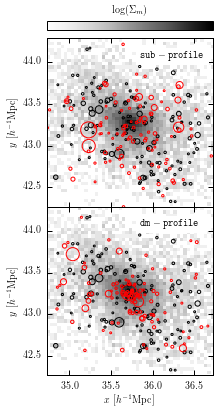

In [17]:
from matplotlib import cm 
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(3.3, 6.0))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.9, bottom=0.1, top=0.88)

#upper panel
ax = axes[0]
ax.set_xlim([x0-dx,x0+dx])
ax.set_ylim([y0-dy,y0+dy])
im1 = ax.imshow(np.flipud(np.log10(surface_density).T), interpolation='nearest',
          extent=[x0-dx, x0+dx, y0-dy, y0+dy], cmap='Greys')

#plot sub-halo positions
for i in range(0,len(x_subs)):
    circle = plt.Circle((x_subs[i], y_subs[i]), rvir[i]/6.0, fill=False, color='black')
    ax.add_artist(circle)
c1 = ax.scatter(x_subs*0, y_subs*0, color='black', s=30, facecolors='none')

#plot clone positions
for i in range(0,len(x_clones_a)):
    circle = plt.Circle((x_clones_a[i], y_clones_a[i]), rvir_clones[i]/6.0, fill=False, color='red')
    ax.add_artist(circle)
c2 = ax.scatter(x_clones_a*0, y_clones_a*0, color='red', s=30, facecolors='none')

ax.text(35.85, 44.05, r'$\tt sub-profile$', fontsize=10, bbox=dict(facecolor='white', alpha=1.0, edgecolor='none'))
ax.set_ylabel(r'$y ~[h^{-1}{\rm Mpc}]$')

#lower panel
ax = axes[1]
ax.set_xlim([x0-dx,x0+dx])
ax.set_ylim([y0-dy,y0+dy])
im2 = ax.imshow(np.flipud(np.log10(surface_density).T), interpolation='nearest',
          extent=[x0-dx, x0+dx, y0-dy, y0+dy], cmap='Greys')

#plot sub-halo positions
for i in range(0,len(x_subs)):
    circle = plt.Circle((x_subs[i], y_subs[i]), rvir[i]/6.0, fill=False, color='black')
    ax.add_artist(circle)

    #plot clone positions
for i in range(0,len(x_clones_b)):
    circle = plt.Circle((x_clones_b[i], y_clones_b[i]), rvir_clones[i]/6.0, fill=False, color='red')
    ax.add_artist(circle)
c3 = ax.scatter(x_clones_b*0, y_clones_b*0, color='orange', s=30, facecolors='none')

ax.set_xlabel(r'$x ~[h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$y ~[h^{-1}{\rm Mpc}]$')
ax.text(35.85, 44.05, r'$\tt dm-profile$', fontsize=10,  bbox=dict(facecolor='white', alpha=1.0, edgecolor='none'))

#colorbar
cbar_ax = fig.add_axes([0.2, 0.9, 0.7, 0.02]) #xmin, ymin, +dx, +dy
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_label(r'$\log(\Sigma_{m})$', labelpad=-23)
cbar.ax.xaxis.set_ticks([])

plt.show()
savepath = PROJECT_DIRECTORY + 'figures/'
filename = 'subhalo_positions.pdf'
fig.savefig(savepath+filename, dpi=500)